In [1]:
import nibabel as nb
print(nb.__version__)

3.2.2


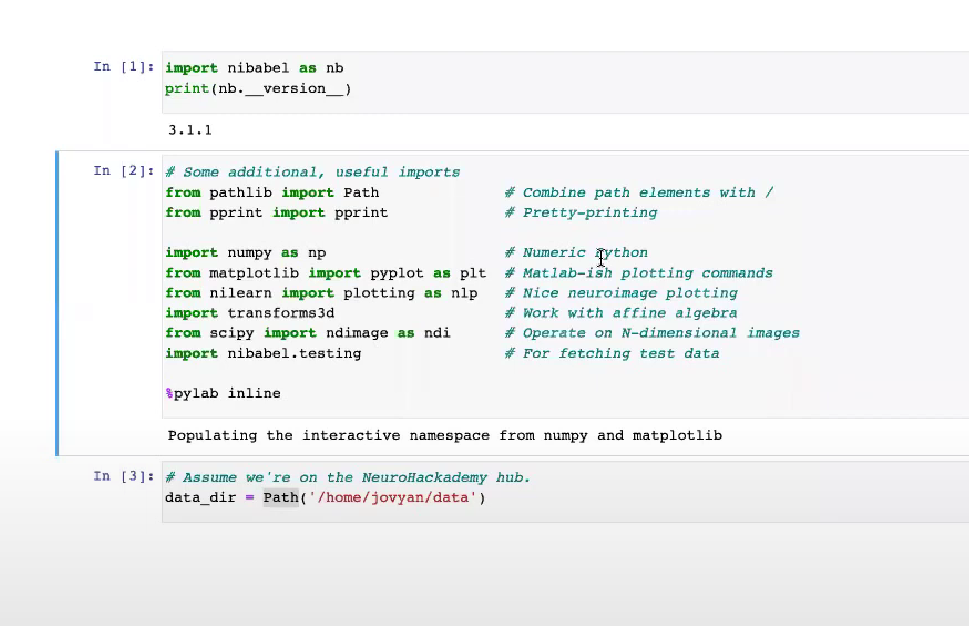

In [2]:
from pathlib import Path
from pprint import pprint

import numpy as np
# from matplotlib import pyplot as plt
# from nilearn import plotting as nlp
# import transforms3d
# from scipy import ndimage as ndi
import nibabel.testing

%matplotlib inline
import matplotlib.pyplot as plt
# %pylab inline

In [5]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [8]:
tf.__version__
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
from numpy import loadtxt
lines = loadtxt("./data/train.txt", dtype=str, delimiter="\n", unpack=True)
# lines

## Get train data inputs

In [70]:
data = []
for row in open("./data/train.txt", 'r'):
        data.append(row.strip().split(","))
# train_names
# content = [ [ float( x ) for x in row.split(',') if x.strip() ] for row in open( filename, 'rt' ) ]
data_arr = np.asarray(data)
data_arr.shape

(434, 2)

In [74]:
data[:5]

[['swbet_cr_128_S_4599_S152517.nii', 'ZK'],
 ['swbet_cr_168_S_6142_S656465.nii', 'AD'],
 ['swbet_cr_011_S_4906_S166475.nii', 'AD'],
 ['swbet_cr_033_S_4505_S141247.nii', 'ZK'],
 ['swbet_cr_114_S_0416_S20620.nii', 'ZK']]

In [15]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "data/RIS-data", x)
    for x in data_arr[data_arr[:,1]=="AD", 0]
]
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "data/RIS-data", x)
    for x in data_arr[data_arr[:,1]=="ZK", 0]
]

In [16]:
print("CT scans with normal tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal tissue: 190
CT scans with abnormal tissue: 244


In [17]:
# AD - alzheimer disease
# ill_images = h[h[:,1]=="AD"][:,0]
# ZK - zdravi mozgani?
# healthy_images = h[h[:,1]=="ZK"][:,0]

In [18]:
# ZK - zdravi mozgani?
# healthy_images = h[h[:,1]=="ZK"][:,0]

## Preprocess data

In [19]:
import nibabel as nib

from scipy import ndimage

In [41]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64 # 64
    desired_width = 91 # 128
    desired_height = 91 # 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [42]:
def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [43]:
processed = process_scan(normal_scan_paths[0])
processed.shape

(91, 91, 64)

In [44]:
# Test data from different dataset
"""
test = read_nifti_file("study_0939.nii")
test_p = process_scan("study_0939.nii")
test.shape, test_p.shape
"""

'\ntest = read_nifti_file("study_0939.nii")\ntest_p = process_scan("study_0939.nii")\ntest.shape, test_p.shape\n'

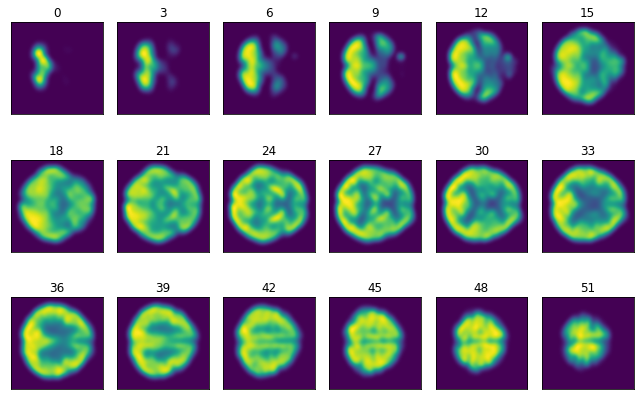

In [91]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']
for i, (ax, method) in enumerate(zip(axs.flat, methods)):
    # img = data[:,x,:]
    num = 3
    ax.imshow(processed[:,:,i*num], interpolation=None)
    ax.set_title(i*num)
plt.tight_layout()
plt.show()

## Build train and validation sets

In [46]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

In [47]:
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

In [48]:
abnormal_cnt, normal_cnt = abnormal_labels.shape[0], normal_labels.shape[0]
abtc = int(abnormal_cnt * 0.7) # abnormal training count
ntc = int(normal_cnt * 0.7) # normal training count
print(f"abnormals: {abnormal_cnt}, normals: {normal_cnt}")
print(f"abnormal training count: {abtc}, normal training count: {ntc}; SUM: {abtc + ntc}")

abnormals: 244, normals: 190
abnormal training count: 170, normal training count: 133; SUM: 303


In [49]:
x_train = np.concatenate((abnormal_scans[:abtc], normal_scans[:ntc]), axis=0)
y_train = np.concatenate((abnormal_labels[:abtc], normal_labels[:ntc]), axis=0)
x_val = np.concatenate((abnormal_scans[abtc:], normal_scans[ntc:]), axis=0)
y_val = np.concatenate((abnormal_labels[abtc:], normal_labels[ntc:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 303 and 131.


## Data augmentation

In [50]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    # volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [51]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (91, 91, 64, 1)


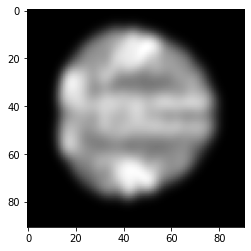

In [52]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 40]), cmap="gray")

In [53]:
image.shape

(91, 91, 64, 1)

## Visualize slices

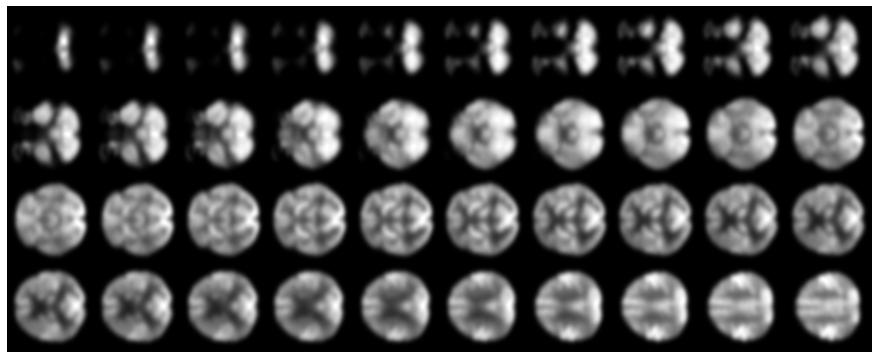

In [55]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 91, 91, image[:, :, :40])

# Neural network

In [56]:
def get_model(width=91, height=91, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=91, height=91)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 91, 91, 64, 1)]   0         
                                                                 
 conv3d_4 (Conv3D)           (None, 89, 89, 62, 64)    1792      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 44, 44, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 44, 44, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 42, 42, 29, 64)    110656    
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 21, 21, 14, 64)   0     

In [57]:
model

# Train model

In [58]:
tf.__version__

'2.8.0'

In [59]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9368448251874233378
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4859428864
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17282641641440709423
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:1e:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [60]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [155]:
# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
152/152 - 21s - loss: 0.5380 - acc: 0.7063 - val_loss: 1.1406 - val_acc: 0.4351 - 21s/epoch - 135ms/step
Epoch 2/100
152/152 - 21s - loss: 0.5606 - acc: 0.6898 - val_loss: 23.2098 - val_acc: 0.5649 - 21s/epoch - 135ms/step
Epoch 3/100
152/152 - 21s - loss: 0.5090 - acc: 0.7426 - val_loss: 3.5154 - val_acc: 0.5649 - 21s/epoch - 135ms/step
Epoch 4/100
152/152 - 21s - loss: 0.5120 - acc: 0.7360 - val_loss: 12.1012 - val_acc: 0.4351 - 21s/epoch - 135ms/step
Epoch 5/100
152/152 - 21s - loss: 0.4434 - acc: 0.7822 - val_loss: 54.7675 - val_acc: 0.5649 - 21s/epoch - 136ms/step
Epoch 6/100
152/152 - 21s - loss: 0.4367 - acc: 0.7855 - val_loss: 40.0004 - val_acc: 0.5649 - 21s/epoch - 136ms/step
Epoch 7/100
152/152 - 21s - loss: 0.4374 - acc: 0.7855 - val_loss: 0.7942 - val_acc: 0.4351 - 21s/epoch - 136ms/step
Epoch 8/100
152/152 - 21s - loss: 0.4564 - acc: 0.7690 - val_loss: 51.6099 - val_acc: 0.5649 - 21s/epoch - 136ms/step
Epoch 9/100
152/152 - 21s - loss: 0.3922 - acc: 0.8251 - va

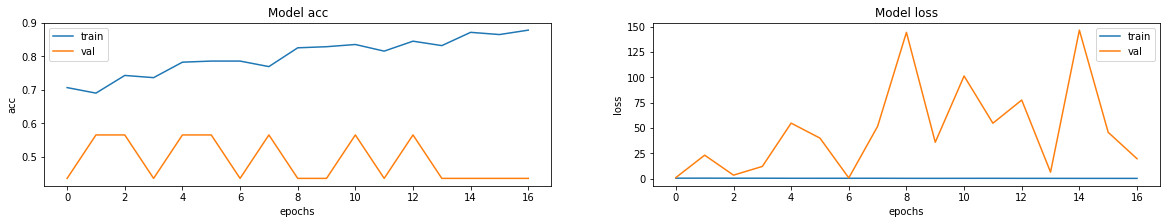

In [157]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Predict (example how it works)

In [158]:
h = np.expand_dims(x_val[2], axis=0)
h.shape

(1, 91, 91, 64)

In [194]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[122], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 85.87 percent confident that CT scan is normal
This model is 14.13 percent confident that CT scan is abnormal


## Test test set

In [181]:
test_data = []
for row in open("./data/test.txt", 'r'):
        test_data.append(row.strip().split(","))
test_data_arr = np.asarray(test_data)
test_data_arr.shape

(187, 1)

In [182]:
test_data_arr[:5]

array([['swbet_cr_033_S_1098_S642411.nii'],
       ['swbet_cr_137_S_4672_S148755.nii'],
       ['swbet_cr_035_S_0555_S24048.nii'],
       ['swbet_cr_127_S_5095_S184611.nii'],
       ['swbet_cr_003_S_4555_S145676.nii']], dtype='<U31')

In [179]:
# TODO at the end switch from data_arr to test_data_arr

test_scan_paths = [
    os.path.join(os.getcwd(), "data/RIS-data", x)
    for x in test_data_arr[:,0]
]

In [180]:
test_scans = np.array([process_scan(path) for path in test_scan_paths])
test_scans.shape

(187, 91, 91, 64)

In [183]:
for scan, path in zip(test_scans, test_data_arr):
    prediction = model.predict(np.expand_dims(scan, axis=0))[0,0]
    print(f"This model is {(100 * score):.2f}% confident that CT scan ('{path[0]}') is abnormal")

This model is 17.99% confident that CT scan ('swbet_cr_033_S_1098_S642411.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_137_S_4672_S148755.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_035_S_0555_S24048.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_127_S_5095_S184611.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_003_S_4555_S145676.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_016_S_5057_S186002.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_027_S_0120_S20592.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_126_S_6683_S805632.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_153_S_4151_S120785.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_036_S_1023_S24722.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_082_S_5184_S191316.nii') is 

This model is 17.99% confident that CT scan ('swbet_cr_011_S_0003_S9228.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_099_S_0090_S11083.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_007_S_4516_S141883.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_100_S_6713_S819691.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_016_S_5032_S186627.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_036_S_4878_S160713.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_037_S_4410_S136277.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_137_S_0301_S13807.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_131_S_0123_S11726.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_035_S_4082_S114427.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_130_S_4971_S175471.nii') is ab

This model is 17.99% confident that CT scan ('swbet_cr_006_S_0547_S18753.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_029_S_4290_S133647.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_130_S_4641_S148021.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_024_S_4223_S123598.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_129_S_6784_S875615.nii') is abnormal
This model is 17.99% confident that CT scan ('swbet_cr_023_S_0031_S95743.nii') is abnormal


## Sources
- Tensorflow
- Cuda
- Matlab
- https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html
- https://github.com/hasibzunair/3D-image-classification-tutorial
- https://keras.io/examples/vision/3D_image_classification/
- https://tiziano.fmf.uni-lj.si/

## Testing zone

In [30]:
img = nb.load('./data/RIS-data/swbet_cr_002_S_0295_S111104.nii')

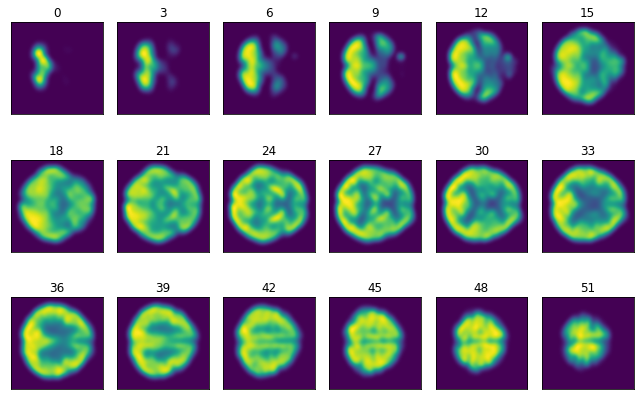

In [156]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, (ax, method) in enumerate(zip(axs.flat, methods)):
    img = x_val[22]
    ax.imshow(img[:,:,i*3], interpolation=None)
    ax.set_title(i*3)
plt.tight_layout()
plt.show()

In [31]:
data = img.get_fdata()

In [40]:
data.shape

(91, 109, 91)

In [71]:
grid = np.random.rand(4, 4)
methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

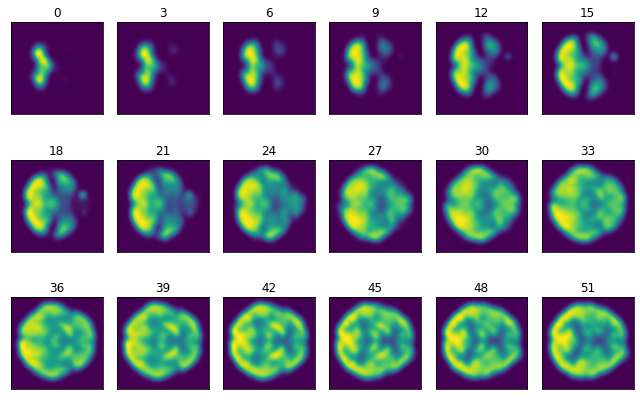

In [581]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, (ax, method) in enumerate(zip(axs.flat, methods)):
    # img = data[:,x,:]
    ax.imshow(processed[:,:,i*3], interpolation=None)
    ax.set_title(i*3)
plt.tight_layout()
plt.show()

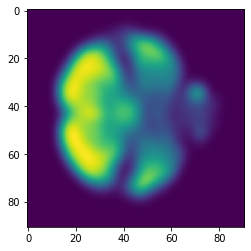

In [599]:
plt.imshow(processed[:,:,20], interpolation=None)

In [594]:
processed[:,:,20].shapey

(91, 91)

In [ ]:
abnormal_cnt, normal_cnt = abnormal_labels.shape[0], normal_labels.shape[0]
abnormal_train_cnt = abnormal_cnt * 0.7
print(f"abnormals: {abnormal_cnt}, normals: {normal_cnt}")

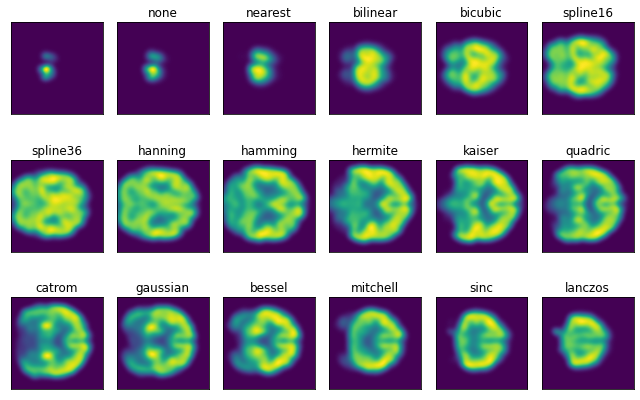

In [396]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, (ax, method) in enumerate(zip(axs.flat, methods)):
    # img = data[:,x,:]
    ax.imshow(unprocessed[:,i*5,:], interpolation=None)
    ax.set_title(method)
plt.tight_layout()
plt.show()